# Проект по предсказанию и предупреждению оттока клиентов
Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.
## Описание услуг
Оператор предоставляет два основных типа услуг: 
 - Стационарную телефонную связь. 
 - Возможно подключение телефонного аппарата к нескольким линиям одновременно.
 - Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.
## Описание данных
Данные состоят из файлов, полученных из разных источников:
contract_new.csv — информация о договоре;
personal_new.csv — персональные данные клиента;
internet_new.csv — информация об интернет-услугах;
phone_new.csv — информация об услугах телефонии.
Во всех файлах столбец customerID содержит код клиента.
Информация о договорах актуальна на 1 февраля 2020.

- personal_new.csv - персональные данные клиента
    - gender - пол
    - SeniorCitizen - наличие пенсионного статуса по возрасту
    - Partner - наличие супруга/супруги
    - Dependents - наличие иждивенцев
- contract_new.csv - информация о договоре
    - BeginDate - дата начала пользования услугами
    - EndDate - дата окончания пользования услугами
    - Type - тип договора: ежемесячный, годовой и т.д
    - PaperlessBilling - выставления счёта по электронной почте
    - PaymentMethod - способ оплаты
    - MonthlyCharges - ежемесячные траты на услуги
    - TotalCharges - всего потрачено денег на услуги
- internet_new.csv - информация об интернет-услугах
    - InternetService - наличие услуг Интернет
    - OnlineSecurity - межсетевой экран
    - OnlineBackup - облачное хранилище файлов для резервного копирования данных
    - DeviceProtection - антивирус
    - TechSupport - выделенная линия технической поддержки
    - StreamingTV - онлайн-ТВ
    - StreamingMovies - онлайн-кинотеатр
- phone_new.csv - информация об услугах телефонии
    - MultipleLines - возможность подключения телефонного аппарата к нескольким линиям одновременно

## Задача:

Мы должны построить модель машинного обучения, которая будет предсказывать отток клиентов, чтобы мы могли в момент понимания, что клиент склонен, уйти сделать ему мотивирующее предложение. Т.о. мы решаем задачу бинарной классификации

Важным критерием для клиента является, чтобы модель была интерпретируемой.

## План работы:
- загрузка и ознакомление с данными
- выделение целевого признака
- формирование синтетических признаков
- заполнение порпусков, устранение аномалий
- объединение данных
- построить графики для визуализации распределния признаков
- построить матрицу распределния признаков, выбрать актуальные
- разделить выборку на тестовую и тренировочну с учетом дизбаланса целевого признака
- построить pipeline с применением трасформатора, масштабирования числовых признаков и OE, OHE кодирование для категориальных признаков
- построить модели логистическую регрессию, случайный лес, catboost, выбрать лучшую из них по кросс-валидации не менее 85% AUC-ROC
- оценить важность признаков по просьбе заказчика для каждой модели
- лучшую модель протестировать на тестовой выборке
- для тестовой модели построить AUC-ROC график и посмотреть accuracy, построить матрицу ошибок 
- общий вывод с рекомендациями

### Анализ и исследование данных

Загрузим данные и посмотрим с чем будем работать 

In [1]:
!pip install phik

In [2]:
#!pip install --upgrade pandas

In [3]:
#!pip install seaborn --upgrade

In [4]:
#!pip install matplotlib --upgrade

In [5]:
!pip install -U scikit-learn

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message=".*is_categorical_dtype is deprecated.*")
warnings.filterwarnings("ignore", category=FutureWarning, message=".*use_inf_as_na option is deprecated.*")
warnings.filterwarnings("ignore", category=UserWarning, message="The figure layout has changed to tight")
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix

In [7]:
try:
    personal_new = pd.read_csv('/datasets/personal_new.csv')
    contract_new = pd.read_csv('/datasets/contract_new.csv')
    internet_new = pd.read_csv('/datasets/internet_new.csv')
    phone_new = pd.read_csv('/datasets/phone_new.csv')
except:
    try:
        personal_new = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
        contract_new = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
        internet_new = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
        phone_new = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')
    except:
        print("Ошибка загрузки")

In [8]:
print(personal_new.info()) # пропусков нет, с данными можно работать
print(personal_new.head(5)) 
personal_new.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None
   customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [9]:
personal_new['SeniorCitizen'].value_counts() # видно что признак представлен как классификация, приведем ее к yes/no

SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64

In [10]:
mapping = {0: 'No', 1: 'Yes'}
personal_new['SeniorCitizen'] = personal_new['SeniorCitizen'].replace(mapping)

In [11]:
print(contract_new.info()) # пропусков нет, TotalCharges в формате строки, нужно будет исправить 
print(contract_new.head(5)) 
contract_new.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
   customerID   BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG  2020-01-01      No  Month-to-month              Yes   
1  5575-GNVDE  2017-04-01      No        One year               No   
2  3668-QPYBK  2019-10-01      No  Month-to-month              Yes   
3  7795-CFOCW  2016-05-01      No        One year               No   
4  9237-HQITU  

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [12]:
contract_new['EndDate'].value_counts()

EndDate
No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-09-01       2
2014-12-01       2
2014-06-01       1
2014-10-01       1
2014-11-01       1
Name: count, Length: 67, dtype: int64

По столбцу EndDate мы можем сформировать наш целевой признак. 1 - будет как ушел. 0 - не ушел. 

In [13]:
contract_new['target_class'] = contract_new['EndDate'].apply(lambda x: 0 if x == 'No' else 1)

In [14]:
contract_new['target_class'].value_counts() # проверка

target_class
0    5942
1    1101
Name: count, dtype: int64

Мы наблюдаем серьезный дизбаланс данных в классификации. Чтобы модель корректно училась нужно будет это учеть при разделе на тренировочную и тестовую выборки, чтобы распределение было равномерным а не случайным. 

Дальше заменим все значения 'No' EndDate на дату окончания сборки файла. Это позволит нам сформировать признак продолжительности использования услуг. 

In [15]:
contract_new['EndDate'] = contract_new['EndDate'].replace('No','2020-02-01') 

In [16]:
contract_new['BeginDate'] = pd.to_datetime(contract_new['BeginDate'])
contract_new['EndDate'] = pd.to_datetime(contract_new['EndDate'])
contract_new['days_using'] = (contract_new['EndDate'] - contract_new['BeginDate']).dt.days
contract_new['days_using'] # мы получили новый признак

0         31
1       1036
2        123
3       1371
4        153
        ... 
7038     730
7039    2191
7040     337
7041     215
7042    2010
Name: days_using, Length: 7043, dtype: int64

Преобразуем TotalCharges в формат числа с плавающей точкой

In [17]:
contract_new[contract_new['TotalCharges'].str.strip() == '']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target_class,days_using
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,0,0


In [18]:
contract_new['TotalCharges'] = contract_new['TotalCharges'].replace(' ', float("NaN"))

In [19]:
contract_new['TotalCharges'] = contract_new['TotalCharges'].astype(float)

In [20]:
contract_new[['TotalCharges']].info() # 11 пропусков

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TotalCharges  7032 non-null   float64
dtypes: float64(1)
memory usage: 55.1 KB


In [21]:
null_total_charges = contract_new[contract_new['TotalCharges'].isnull()]
null_total_charges # клиенты только зарегистрировались и не успели ничего оплатить, поэтому у них нет оплаты. Заменим пропуски на 0

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target_class,days_using
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0,0


In [22]:
contract_new['TotalCharges'] = contract_new['TotalCharges'].fillna(0)

In [23]:
contract_new.describe()

,BeginDate,EndDate,MonthlyCharges,TotalCharges,target_class,days_using
count,7043,7043,7043.000000,7043.000000,7043.000000,7043.000000
mean,2017-04-30 13:01:50.918642688,2019-10-16 02:22:05.912253440,64.761692,2115.312885,0.156325,898.555729
min,2013-10-01 00:00:00,2014-06-01 00:00:00,18.250000,0.000000,0.000000,0.000000
25%,2015-06-01 00:00:00,2020-02-01 00:00:00,35.500000,436.750000,0.000000,276.000000
50%,2017-09-01 00:00:00,2020-02-01 00:00:00,70.350000,1343.350000,0.000000,761.000000
75%,2019-04-01 00:00:00,2020-02-01 00:00:00,89.850000,3236.690000,0.000000,1461.000000
max,2020-02-01 00:00:00,2020-02-01 00:00:00,118.750000,9221.380000,1.000000,2314.000000
std,NaN,NaN,30.090047,2112.742814,0.363189,683.130510


In [24]:
print(internet_new.info()) # пропусков нет, везде по 2 признака в категориях
print(internet_new.head(5)) 
internet_new.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None
   customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes 

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [25]:
print(phone_new.info()) # пропусков нет, везде по 2 признака в категориях
print(phone_new.head(5)) 
phone_new.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None
   customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


Первичное ознакомление завершено. Мы выделили целевой признак, создали один новый, так же поработали с неверными форматами и заполнили пропуски. Теперь объединим данные в одну таблицу и попробуем визуализировать распределение признаков.

In [26]:
df = pd.merge(personal_new, contract_new, on='customerID', how='outer').merge(internet_new, on='customerID', how='outer').merge(phone_new, on='customerID', how='outer')
print(df.info())
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   gender            7043 non-null   object        
 2   SeniorCitizen     7043 non-null   object        
 3   Partner           7043 non-null   object        
 4   Dependents        7043 non-null   object        
 5   BeginDate         7043 non-null   datetime64[ns]
 6   EndDate           7043 non-null   datetime64[ns]
 7   Type              7043 non-null   object        
 8   PaperlessBilling  7043 non-null   object        
 9   PaymentMethod     7043 non-null   object        
 10  MonthlyCharges    7043 non-null   float64       
 11  TotalCharges      7043 non-null   float64       
 12  target_class      7043 non-null   int64         
 13  days_using        7043 non-null   int64         
 14  InternetService   5517 n

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,target_class,days_using,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Female,No,Yes,No,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,...,0,31,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,No,No,No,2017-04-01,2020-02-01,One year,No,Mailed check,...,0,1036,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,No,No,No,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,...,0,123,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,No,No,No,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),...,0,1371,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,No,No,No,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,...,0,153,Fiber optic,No,No,No,No,No,No,No


После объединения, мы видим, что часть данных отсуствует, так как в таблицах contract_new и personal_new было по 7043 строк, а в internet_new было 5517 и phone_new - 6361 . Таким образом данных о пользователях больше чем данных об услугах. Если мы удалим недостающие данные, то можем потерять много инфромации. Я попробую заполнить пропуски "other"

In [27]:
df = df.fillna('other')
df.info() # проверка

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   gender            7043 non-null   object        
 2   SeniorCitizen     7043 non-null   object        
 3   Partner           7043 non-null   object        
 4   Dependents        7043 non-null   object        
 5   BeginDate         7043 non-null   datetime64[ns]
 6   EndDate           7043 non-null   datetime64[ns]
 7   Type              7043 non-null   object        
 8   PaperlessBilling  7043 non-null   object        
 9   PaymentMethod     7043 non-null   object        
 10  MonthlyCharges    7043 non-null   float64       
 11  TotalCharges      7043 non-null   float64       
 12  target_class      7043 non-null   int64         
 13  days_using        7043 non-null   int64         
 14  InternetService   7043 n

Построим несколько графиков чтобы посмотреть как распределны наши данные более нагрядно

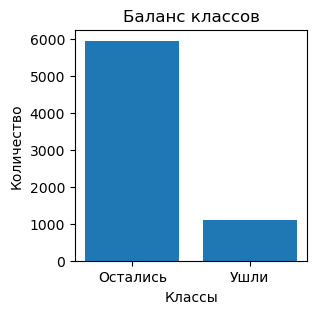

In [28]:
class_counts = [df['target_class'].value_counts()[0], df['target_class'].value_counts()[1]]
class_labels = ['Остались', 'Ушли']

plt.figure(figsize=(3, 3))
plt.bar(class_labels, class_counts)
plt.xlabel('Классы')
plt.ylabel('Количество')
plt.title('Баланс классов')

plt.show()

Мы получили визуально подтверждение дизбаланса целевого признака

In [29]:
df.columns # получу список колонок

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'target_class', 'days_using',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'],
      dtype='object')

Посмотрим на графики с численными значениями

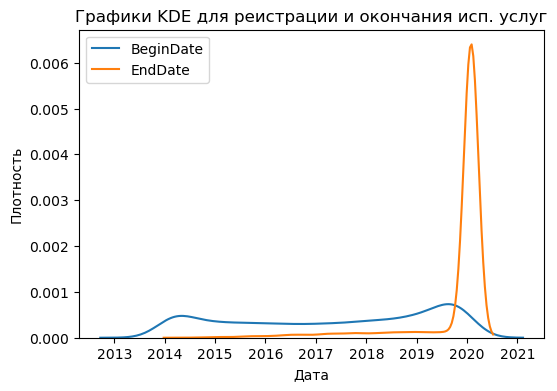

In [30]:
numerical_features = ['BeginDate', 'EndDate']

plt.figure(figsize=(6, 4))
for feature in numerical_features:
    sns.kdeplot(data=df, x=feature, label=feature)

plt.xlabel('Дата')
plt.ylabel('Плотность')
plt.title('Графики KDE для реистрации и окончания исп. услуг')
plt.legend()
plt.show()

Высокий скачек на 2020 говорит не о резкой утечке клиентов, это все клиенты которые оставили подписку, просто мы создали этот признак как дата окончания, чтобы посчитать количество дней

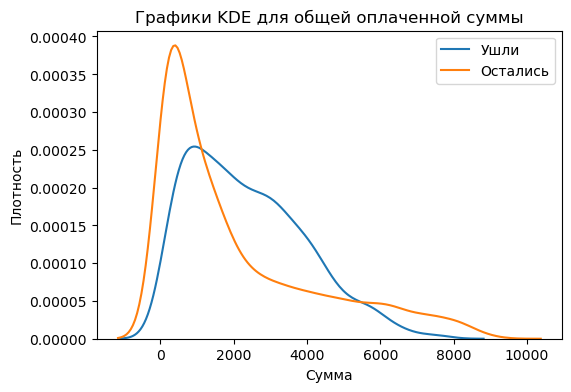

In [31]:
plt.figure(figsize=(6, 4))

sns.kdeplot(data=df.query('target_class==1'), x='TotalCharges')
sns.kdeplot(data=df.query('target_class==0'), x='TotalCharges')

plt.xlabel('Сумма')
plt.ylabel('Плотность')
plt.title('Графики KDE для общей оплаченной суммы')
plt.legend(["Ушли", "Остались"])
plt.show()

In [32]:
df['TotalCharges'].median()

1343.35

График и медианный показатель указывают что основная масса клиентов внесли оплату в сумме 1350 долларов и даллее постепенный спуск в сторону увеличения суммы.

Анализ ушедших клиентов показывает что среди них удоходят большое количество клиентов с бОльшими чеками, чем в среднем графике по этому признаку.

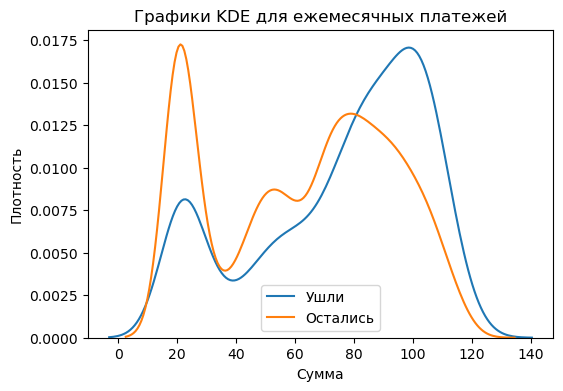

In [33]:
plt.figure(figsize=(6, 4))

sns.kdeplot(data=df.query('target_class==1'), x='MonthlyCharges')
sns.kdeplot(data=df.query('target_class==0'), x='MonthlyCharges')

plt.xlabel('Сумма')
plt.ylabel('Плотность')
plt.title('Графики KDE для ежемесячных платежей')
plt.legend(["Ушли", "Остались"])
plt.show()

По ежемесячной подписке мы видим 2 тренда, 20 долларов и два пика на 50 и 80 долларов. Скорее всего клиенты делятся на тех кто пользуется только основной подпиской и больше ничем и те кто пользуются несколькими продуктами.

Среди бывших клиентов не так много тех у кого маленькая сумма платежа, зато с другой стороны ключевые клиенты с большим чеком склонны уходить 

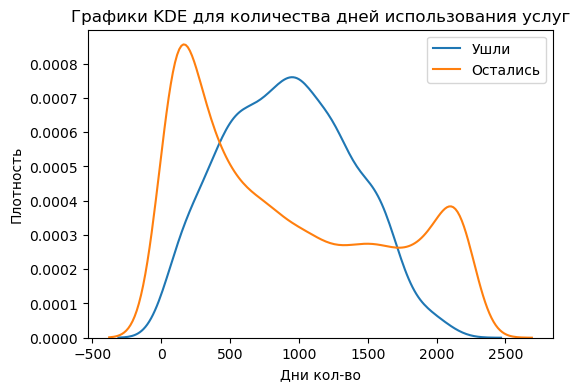

In [34]:
plt.figure(figsize=(6, 4))

sns.kdeplot(data=df.query('target_class==1'), x='days_using')
sns.kdeplot(data=df.query('target_class==0'), x='days_using')

plt.xlabel('Дни кол-во')
plt.ylabel('Плотность')
plt.title('Графики KDE для количества дней использования услуг')
plt.legend(["Ушли", "Остались"])
plt.show()

Так же мы видим разные графики для бывших и текущих клиентов. Бывшие клиенты в общей массе пользовались сервисом 1000 дней и с равной вероятностью вокруг этой даты могли отказаться от услуг.

Теперь посмотрим на категориальные признаки:

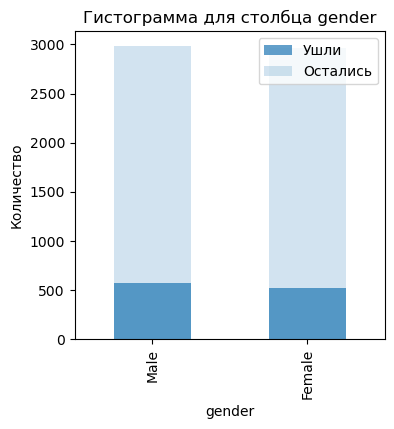

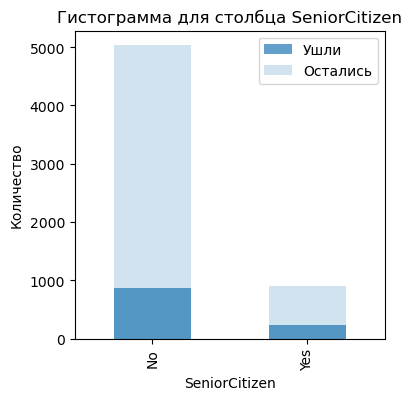

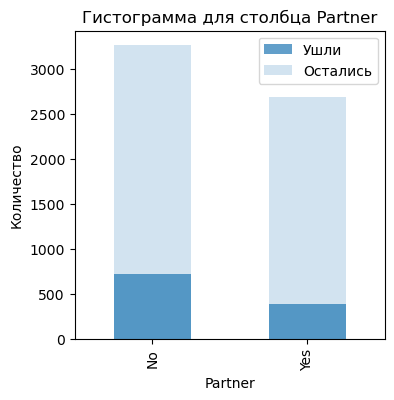

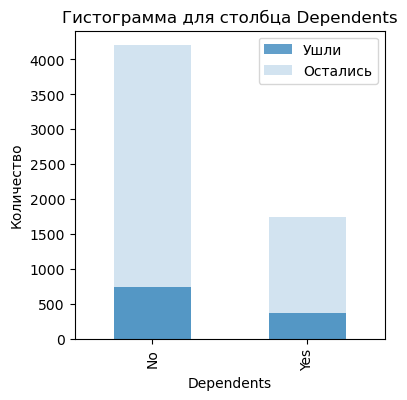

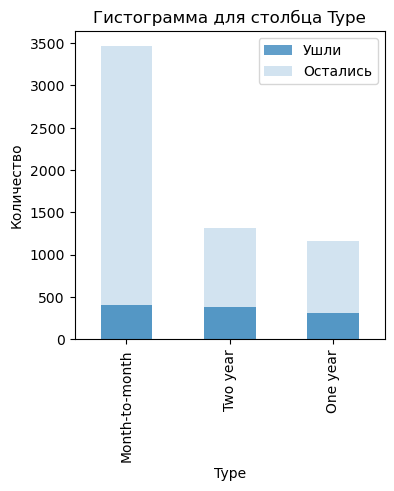

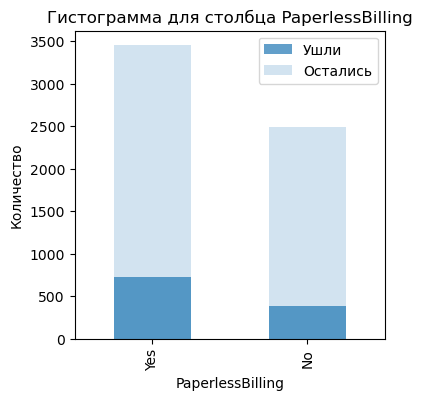

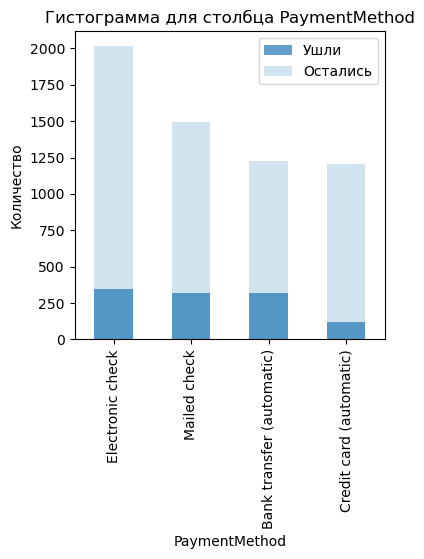

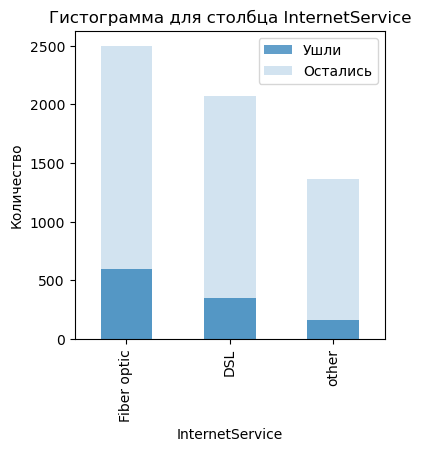

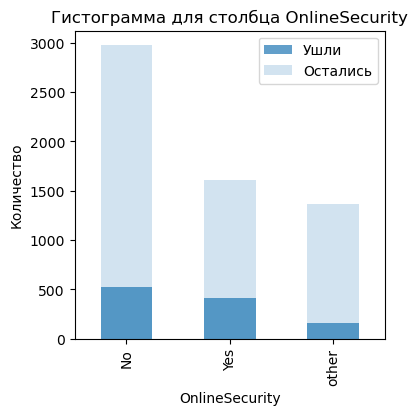

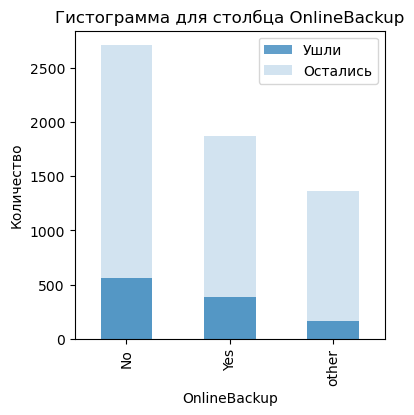

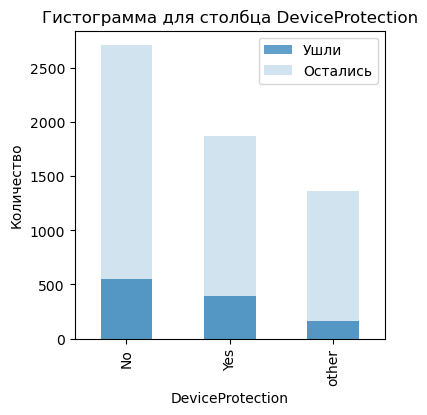

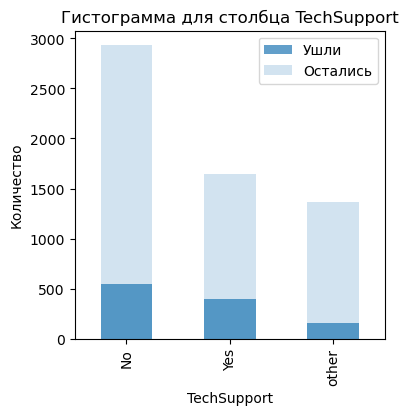

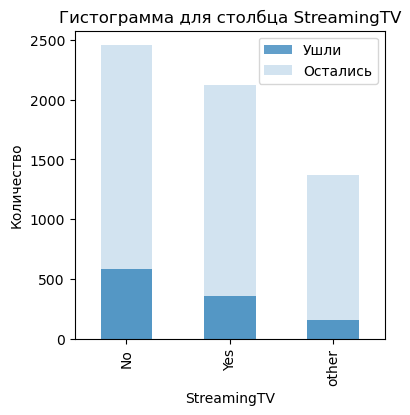

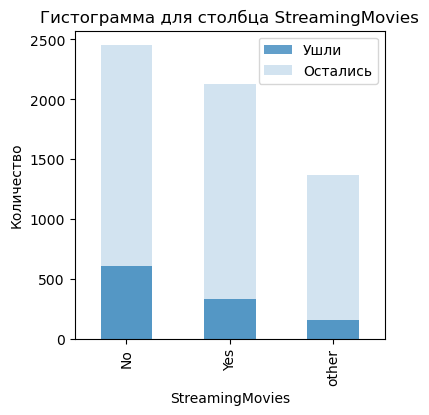

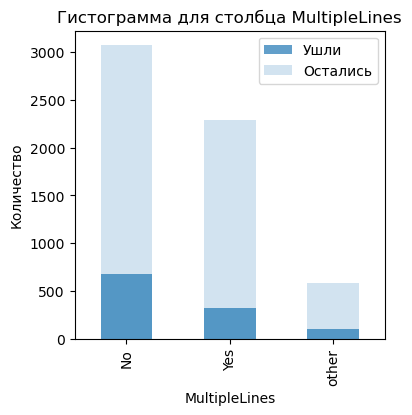

In [35]:
target_1_cols = df.query('target_class==1')
target_0_cols = df.query('target_class==0')

categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Type', 'PaperlessBilling', 'PaymentMethod',
                    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

for col in categorical_cols:
    plt.figure(figsize=(4, 4))
    target_1_cols[col].value_counts().plot.bar(label='Ушли', alpha=0.7)
    target_0_cols[col].value_counts().plot.bar(label='Остались', alpha=0.2)
    plt.xlabel(col)
    plt.ylabel('Количество')
    plt.title(f'Гистограмма для столбца {col}')
    plt.legend()
    plt.show()

Гистограммы распределения количества категориальных признаков показывают, что распределение ушедшедших и оставшихся клиентов повторяется по категориям. 

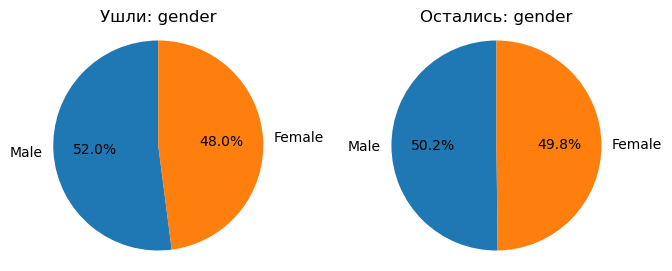

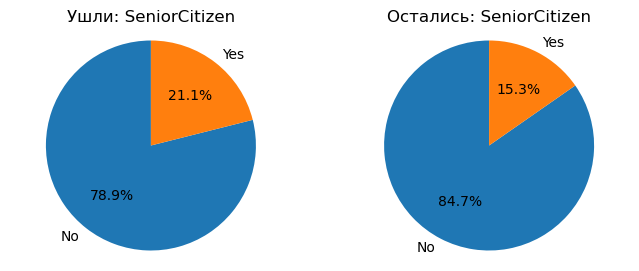

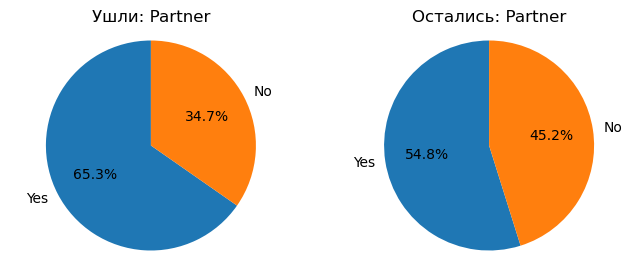

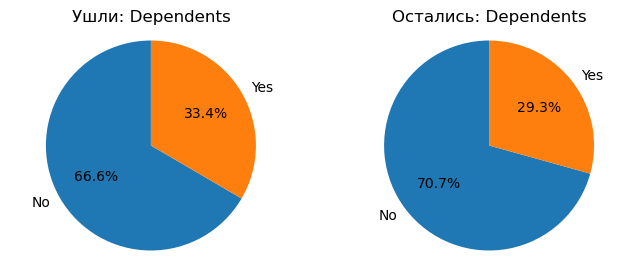

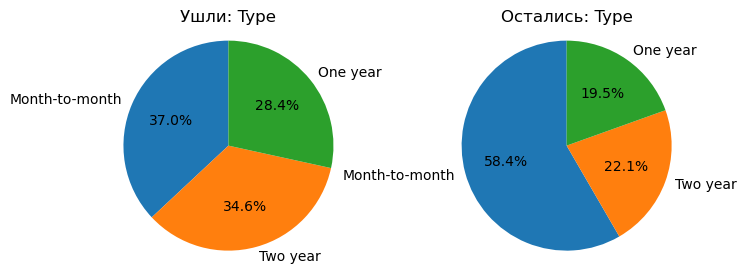

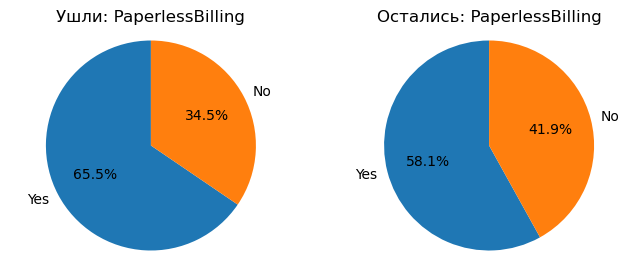

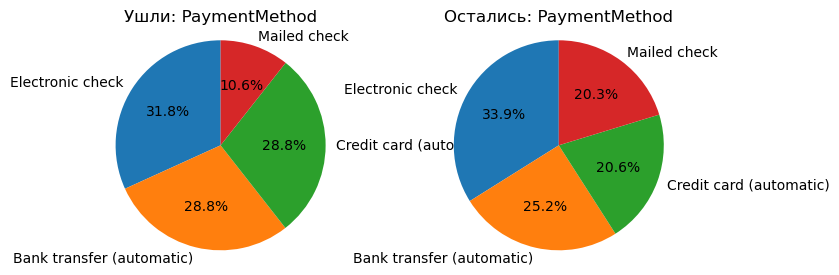

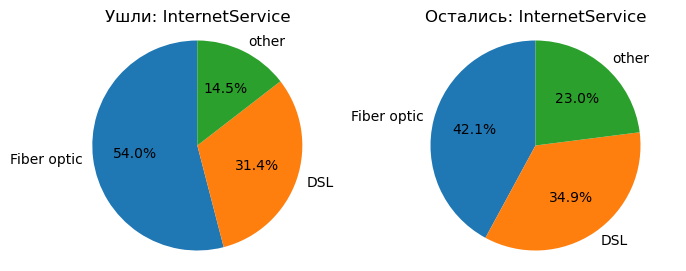

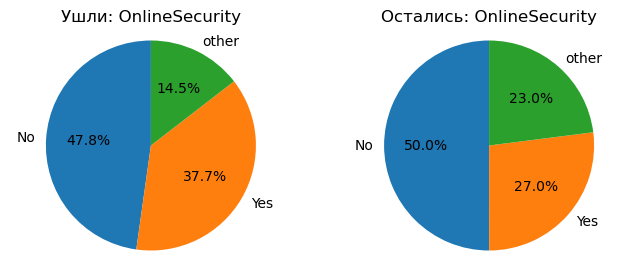

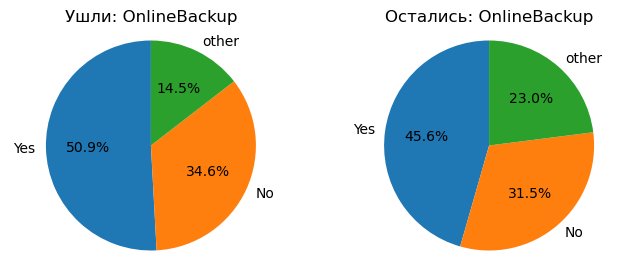

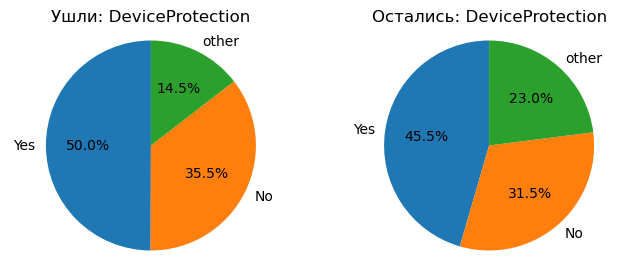

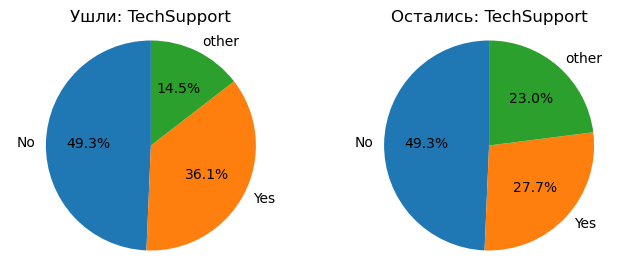

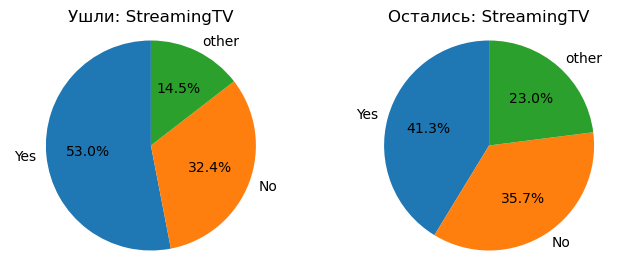

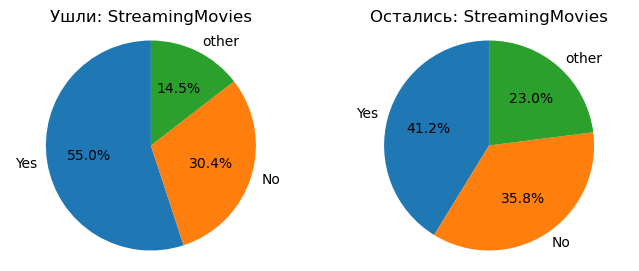

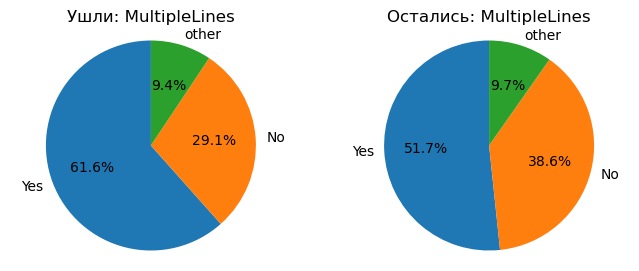

In [36]:
target_1_cols = df[df['target_class'] == 1]
target_0_cols = df[df['target_class'] == 0]

for column in categorical_cols:
    target_1_counts = target_1_cols[column].value_counts()
    target_0_counts = target_0_cols[column].value_counts()

    labels = target_1_counts.index
    sizes_target_1 = target_1_counts.values
    sizes_target_0 = target_0_counts.values

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
    ax1.pie(sizes_target_1, labels=labels, autopct='%1.1f%%', startangle=90)
    ax1.set_title('Ушли: ' + column)
    ax1.axis('equal')

    ax2.pie(sizes_target_0, labels=labels, autopct='%1.1f%%', startangle=90)
    ax2.set_title('Остались: ' + column)
    ax2.axis('equal')

    plt.show()

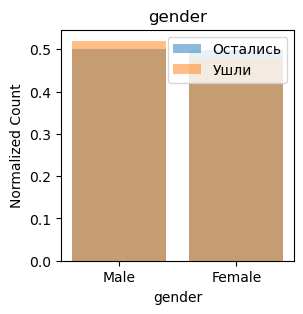

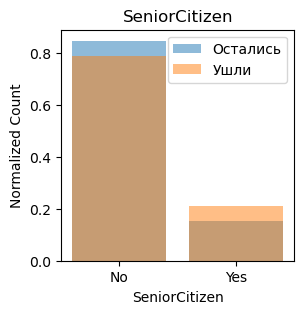

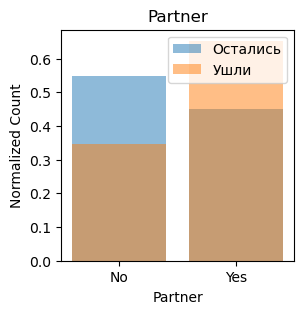

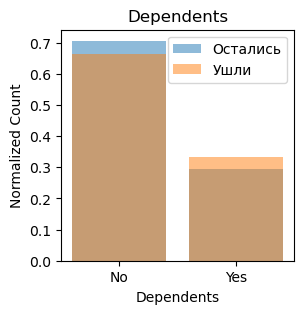

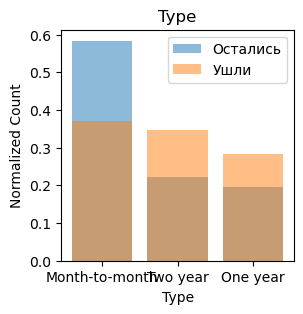

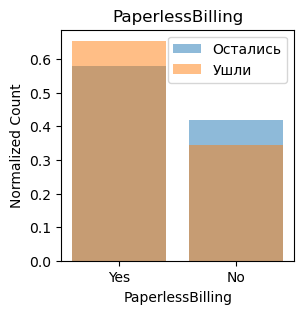

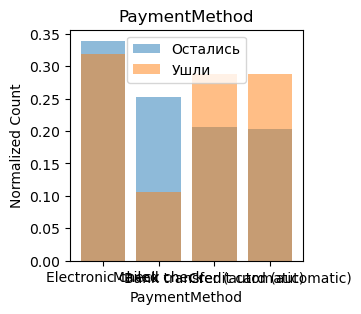

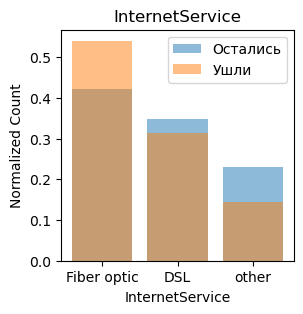

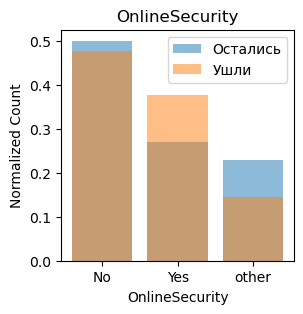

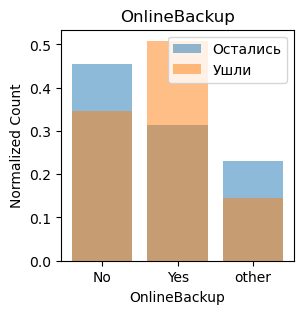

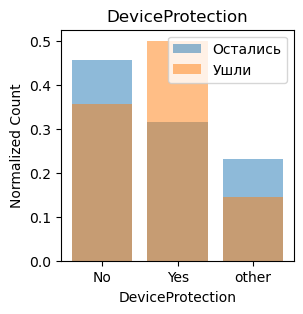

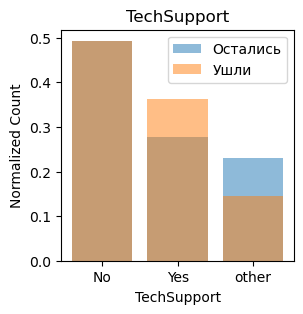

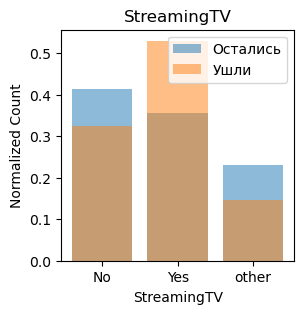

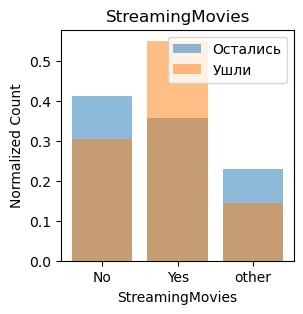

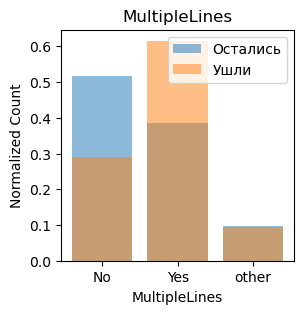

In [37]:
target_1_cols = df.query('target_class==1')
target_0_cols = df.query('target_class==0')

features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Type', 'PaperlessBilling', 'PaymentMethod',
            'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
            'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

for feature in features:
    plt.figure(figsize=(3, 3))
    normalized_counts_0 = target_0_cols[feature].value_counts(normalize=True)
    normalized_counts_1 = target_1_cols[feature].value_counts(normalize=True)
    plt.bar(normalized_counts_0.index, normalized_counts_0.values, label='Остались', alpha=0.5)
    plt.bar(normalized_counts_1.index, normalized_counts_1.values, label='Ушли', alpha=0.5)
    plt.title(feature)
    plt.xlabel(feature)
    plt.ylabel('Normalized Count')
    plt.legend()
    plt.show()

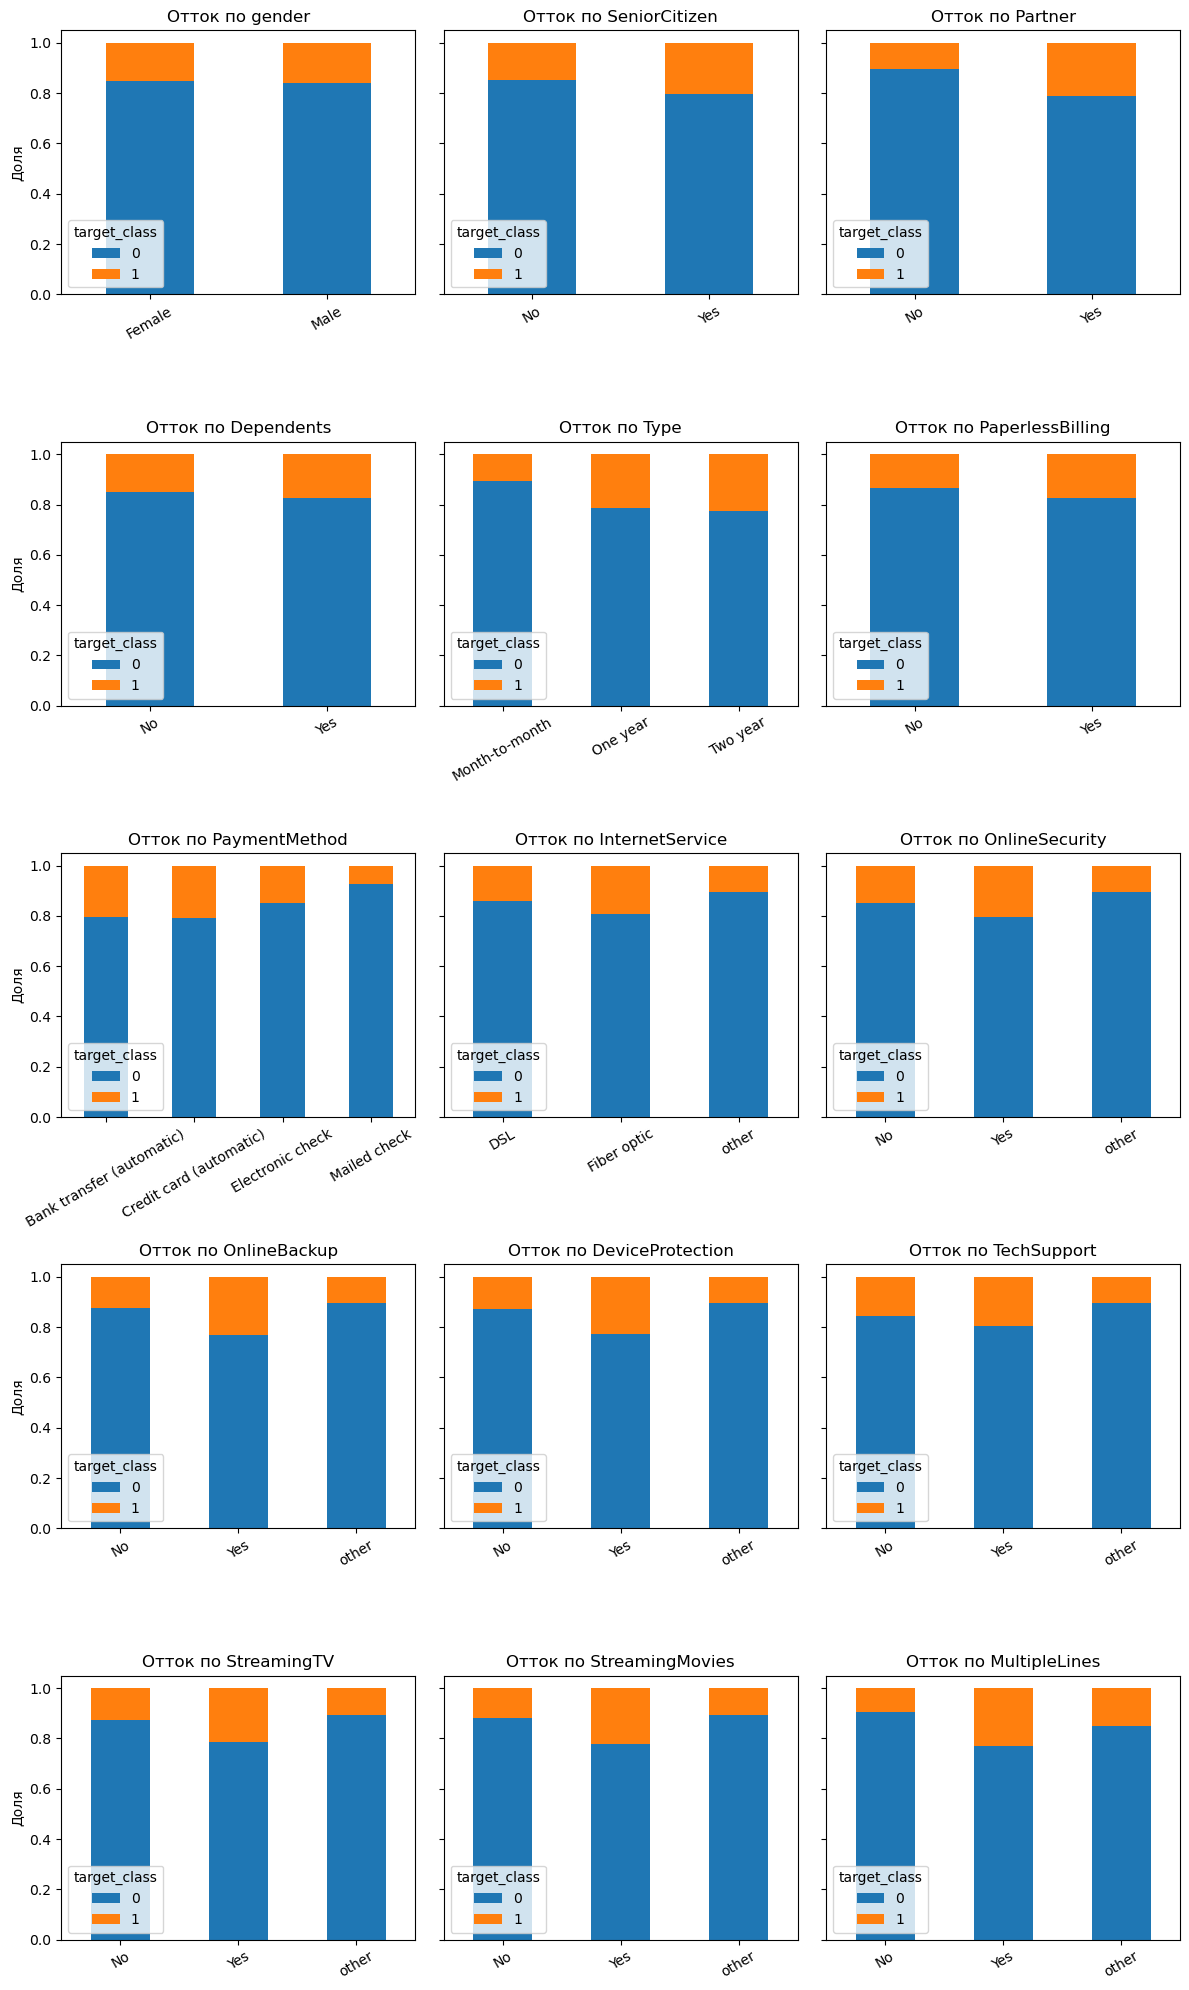

In [38]:
fig, axes = plt.subplots(nrows=5, ncols=3, sharey=True, figsize=(12, 20))

for feature, ax in zip(features, axes.flatten()):
    tmp_df = df.pivot_table(index='target_class', columns=feature, values='customerID', aggfunc='count')
    tmp_df = tmp_df.div(tmp_df.sum(axis=0), axis=1).T

    tmp_df.plot.bar(stacked=True, rot=30, ax=ax)

    ax.set_title(f'Отток по {feature}')
    ax.set_xlabel(None)
    ax.set_ylabel('Доля')
    
plt.tight_layout()
plt.show()

Построим матрицу корреляций, чтобы выбрать признаки которые мы дальше будем использовать в моделях.

In [39]:
df[['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'target_class', 'days_using',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']].phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'days_using'])

,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,...,target_class,days_using,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
gender,1.000000,0.000000,0.000000,0.000000,0.011268,0.018274,0.000000,0.000000,0.000000,0.008175,...,0.008581,0.000000,0.000000,0.001460,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SeniorCitizen,0.000000,1.000000,0.016992,0.324576,0.050862,0.090502,0.086231,0.242133,0.292725,0.304985,...,0.086159,0.063315,0.160702,0.127319,0.109995,0.110177,0.135283,0.111714,0.113778,0.087925
Partner,0.000000,0.016992,1.000000,0.652122,0.473514,0.177492,0.179736,0.013218,0.243008,0.203545,...,0.226688,0.453688,0.000000,0.091202,0.092012,0.100092,0.076326,0.082251,0.077506,0.086249
Dependents,0.000000,0.324576,0.652122,1.000000,0.208564,0.055518,0.147680,0.172593,0.224903,0.184366,...,0.046871,0.198729,0.108463,0.117219,0.097766,0.094597,0.109753,0.088193,0.084684,0.011198
BeginDate,0.011268,0.050862,0.473514,0.208564,1.000000,0.548313,0.766249,0.081447,0.456389,0.421886,...,0.450254,0.978521,0.192197,0.460712,0.496176,0.502422,0.455418,0.419599,0.431137,0.468035
EndDate,0.018274,0.090502,0.177492,0.055518,0.548313,1.000000,0.285429,0.062936,0.169262,0.173493,...,1.000000,0.396342,0.117099,0.166235,0.236373,0.225828,0.150303,0.185980,0.199118,0.249504
Type,0.000000,0.086231,0.179736,0.147680,0.766249,0.285429,1.000000,0.106860,0.277462,0.388444,...,0.094015,0.634155,0.505187,0.636884,0.581660,0.631531,0.671629,0.549564,0.553556,0.244410
PaperlessBilling,0.000000,0.242133,0.013218,0.172593,0.081447,0.062936,0.106860,1.000000,0.370495,0.467812,...,0.083398,0.026799,0.231438,0.208320,0.195321,0.195687,0.200621,0.204717,0.202241,0.099953
PaymentMethod,0.000000,0.292725,0.243008,0.224903,0.456389,0.169262,0.277462,0.370495,1.000000,0.399526,...,0.214832,0.350964,0.323886,0.315799,0.293413,0.297923,0.317713,0.284531,0.285525,0.174849
MonthlyCharges,0.008175,0.304985,0.203545,0.184366,0.421886,0.173493,0.388444,0.467812,0.399526,1.000000,...,0.226280,0.387727,0.919002,0.812632,0.818851,0.827272,0.816660,0.864677,0.863616,0.709983


Я уберу признаки со слабой зависимостью к целевому признаку менее 8%, а так же OnlineBackup имеет 95% коллениарность с StreamingMovies и DeviceProtection. Это может негативно сказаться на обучении модели.

Есть так же несколько признаков с 85% коллениарности. Их я пока оставлю.

Так же я уберу признаки с датами так как уже создан признак days_using который отражает их силу

In [40]:
df[['SeniorCitizen', 'Partner','Type', 'PaperlessBilling', 'PaymentMethod',
    'MonthlyCharges', 'TotalCharges', 'target_class', 'days_using',
    'OnlineBackup', 'MultipleLines']].phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'days_using'])

,SeniorCitizen,Partner,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target_class,days_using,OnlineBackup,MultipleLines
SeniorCitizen,1.000000,0.016992,0.086231,0.242133,0.292725,0.304985,0.135650,0.086159,0.063315,0.109995,0.087925
Partner,0.016992,1.000000,0.179736,0.013218,0.243008,0.203545,0.381958,0.226688,0.453688,0.092012,0.086249
Type,0.086231,0.179736,1.000000,0.106860,0.277462,0.388444,0.470860,0.094015,0.634155,0.581660,0.244410
PaperlessBilling,0.242133,0.013218,0.106860,1.000000,0.370495,0.467812,0.201703,0.083398,0.026799,0.195321,0.099953
PaymentMethod,0.292725,0.243008,0.277462,0.370495,1.000000,0.399526,0.335666,0.214832,0.350964,0.293413,0.174849
MonthlyCharges,0.304985,0.203545,0.388444,0.467812,0.399526,1.000000,0.710905,0.226280,0.387727,0.818851,0.709983
TotalCharges,0.135650,0.381958,0.470860,0.201703,0.335666,0.710905,1.000000,0.302890,0.848337,0.550544,0.467787
target_class,0.086159,0.226688,0.094015,0.083398,0.214832,0.226280,0.302890,1.000000,0.374569,0.089704,0.105101
days_using,0.063315,0.453688,0.634155,0.026799,0.350964,0.387727,0.848337,0.374569,1.000000,0.366170,0.347289
OnlineBackup,0.109995,0.092012,0.581660,0.195321,0.293413,0.818851,0.550544,0.089704,0.366170,1.000000,0.562933


In [41]:
phik_overview = df[['SeniorCitizen', 'Partner','Type', 'PaperlessBilling', 'PaymentMethod',
    'MonthlyCharges', 'TotalCharges', 'target_class', 'days_using',
    'OnlineBackup', 'MultipleLines']].phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'days_using'])

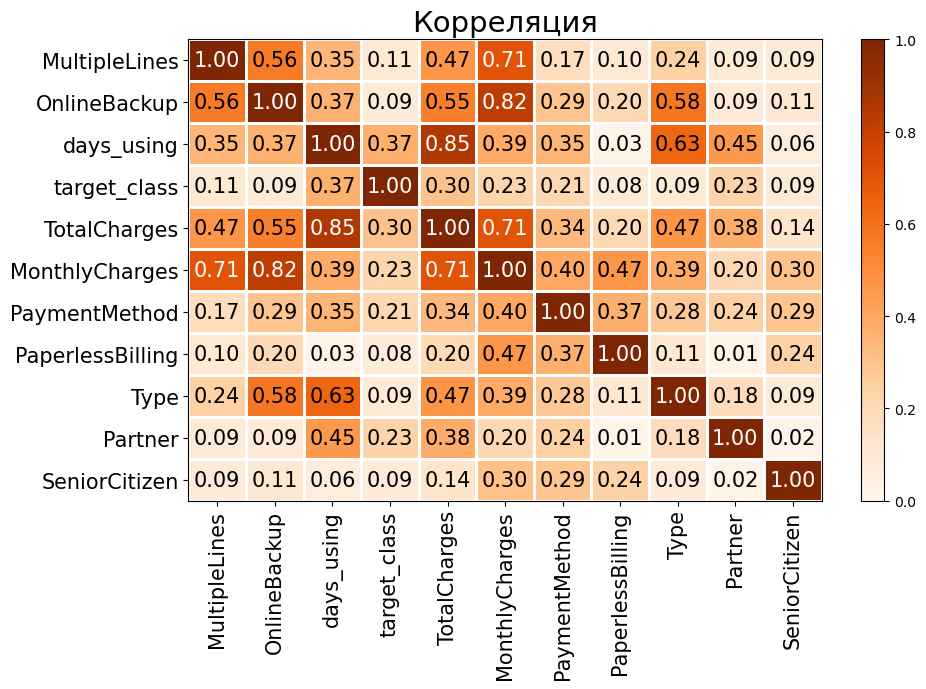

In [42]:
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Oranges', title=r'Корреляция', fontsize_factor=1.5,
                        figsize=(10,7))
plt.tight_layout()

Мы получили список признаков, можем приступать к след этапу и поделить выборку на тренировочную и тестовую.

## Обработка признаков и обучение моделей

Разобью нашу выборку на тренировочную и тестовую.

In [43]:
target = df['target_class']
features = df[['SeniorCitizen', 'Partner','Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
               'TotalCharges', 'target_class', 'days_using', 'OnlineBackup', 'MultipleLines']].drop(['target_class'],axis=1)
RANDOM_STATE = 28082023

In [44]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, 
                                                                            random_state=RANDOM_STATE, stratify=target)
print(features_train.shape,features_test.shape)

(5282, 10) (1761, 10)


Для разных моделей лучше будет использовать разное кодирование

In [45]:
ohe_features_train = features_train.select_dtypes(include='object').columns.to_list()
print(ohe_features_train) # категориальные признаки OHE для линейной модели

oe_features_train = ohe_features_train.copy() # категориальные признаки OE для "деревянных" моделей

numeric_features_train = features_train.select_dtypes(exclude='object').columns.to_list()
numeric_features_train # числовые признаки

['SeniorCitizen', 'Partner', 'Type', 'PaperlessBilling', 'PaymentMethod', 'OnlineBackup', 'MultipleLines']


['MonthlyCharges', 'TotalCharges', 'days_using']

### Логистическая регрессия

Создаем трансформер для категориальных и числовых признаков

In [46]:
column_transformer = make_column_transformer(
    (StandardScaler(), numeric_features_train),
    (OneHotEncoder(), ohe_features_train),
    remainder='passthrough' 
)

Создаем конвеер для трасформера и модели логистической регрессии

In [47]:
linear_reg = make_pipeline(
    column_transformer,
    LogisticRegression(class_weight='balanced',solver='liblinear',random_state=RANDOM_STATE)
)

Создаем и обучаем GridSearchCV на основе pipeline

In [48]:
grid_space = {
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__C': [13, 17, 15]
}

grid = GridSearchCV(linear_reg, scoring='roc_auc', param_grid=grid_space, cv=10, n_jobs=-1)

grid.fit(features_train, target_train)

print('Лучшие гиперпараметры: ', grid.best_params_)
print('Лучший результат roc_auc: ', grid.best_score_)

Лучшие гиперпараметры:  {'logisticregression__C': 15, 'logisticregression__penalty': 'l2'}
Лучший результат roc_auc:  0.7646285236185528


Мы получили результат в 0.7646. Этого пока недостаточно, для перехода к тестовой выборке надо минимум 0.85

Выведем веса чтобы оценить важность признаков

In [49]:
pd.Series(
    data = grid.best_estimator_[-1].coef_[0],
    index = grid.best_estimator_[:-1].get_feature_names_out()
).abs().sort_values(ascending=False)

standardscaler__MonthlyCharges                            1.246914
standardscaler__TotalCharges                              1.213865
onehotencoder__Type_Month-to-month                        0.956773
onehotencoder__MultipleLines_other                        0.650040
onehotencoder__MultipleLines_No                           0.618877
onehotencoder__Type_Two year                              0.605155
onehotencoder__OnlineBackup_other                         0.574109
onehotencoder__PaymentMethod_Mailed check                 0.531437
onehotencoder__OnlineBackup_No                            0.509137
onehotencoder__Type_One year                              0.467319
onehotencoder__PaymentMethod_Credit card (automatic)      0.404160
onehotencoder__Partner_Yes                                0.352168
onehotencoder__PaymentMethod_Bank transfer (automatic)    0.277666
onehotencoder__SeniorCitizen_Yes                          0.260211
onehotencoder__Partner_No                                 0.23

Вы деляется признак Type, возможно если мы его уберем модель покажет лучше результат

По важности признаков видно, что Наиболее важные для модели признаки модель оценила числовые признаки MonthlyCharges и TotalCharges, в то время как числовой признак days_using является одним из наиболее слабых, что несколько противоречит бытовой логике, что чем дольше клиент пользуется услугами тем он лояльнее. Я попробую убрать days_using, так как если я уберу PaperlessBilling, то уйдет не только значение No с нулевой важностью но и Yes с 0.11 важности

In [50]:
column_transformer = make_column_transformer(
    (StandardScaler(), ['MonthlyCharges', 'TotalCharges']),
    (OneHotEncoder(), ohe_features_train),
    remainder='passthrough'
)

linear_reg = make_pipeline(
    column_transformer,
    LogisticRegression(class_weight='balanced',solver='liblinear',random_state=RANDOM_STATE)
)

grid_space = {
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__C': [20, 15, 25]
}

grid = GridSearchCV(linear_reg, scoring='roc_auc', param_grid=grid_space, cv=10, n_jobs=-1)

grid.fit(features_train[['SeniorCitizen', 'Partner', 'Type', 'PaperlessBilling', 'PaymentMethod', 'OnlineBackup', 'MultipleLines', 'MonthlyCharges', 'TotalCharges']], target_train)
linear_roc_auc = grid.best_score_

print('Лучшие гиперпараметры: ', grid.best_params_)
print('Лучший результат roc_auc: ', linear_roc_auc)

Лучшие гиперпараметры:  {'logisticregression__C': 20, 'logisticregression__penalty': 'l2'}
Лучший результат roc_auc:  0.7651927290051586


Лучший результат roc_auc:  0.7652. Без признака days_using модель стала лучше но изменение несущественно.

### Случайный лес

Я произведу тот же порядок что и в логистической регрессии, только заменю ОНЕ на ОЕ, а так же выберу гиперпараметры. Я уже перебрал во время поиска лучших параметров варианты глубины от 3 до 12 и количество деверьев до 200. В данном тесте я ограничил промежутки, чтобы во время проверки было не слишком долго. Результат становился не сильно лучше, но обобщающая способность скорее всего становится только хуже ,если слишком моного ответвлений и модель просто зубрит правильные варианты

In [51]:
column_transformer = make_column_transformer(
    (StandardScaler(), numeric_features_train),
    (OrdinalEncoder(), oe_features_train),
    remainder='passthrough' 
)
random_for = make_pipeline(
    column_transformer,
    RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
)
grid_space = {
   'randomforestclassifier__max_depth':[x for x in range(6,9,1)], 
   'randomforestclassifier__n_estimators':[x for x in range(31,38,3)]
}

grid = GridSearchCV(random_for, scoring='roc_auc', param_grid=grid_space, cv=10, n_jobs=-1)

grid.fit(features_train, target_train)

print('Лучшие гиперпараметры: ', grid.best_params_)
print('Лучший результат roc_auc: ', grid.best_score_)

Лучшие гиперпараметры:  {'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 34}
Лучший результат roc_auc:  0.8235040682437219


Полученный результат в 0.8235 на ROC_AUC лучше чем был в логистической регрессии но все еще не дотягивает до качества которого мы хотим видеть

Теперь я попробую оценить важность признаков

In [52]:
pd.Series(
    data = grid.best_estimator_[-1].feature_importances_,
    index = grid.best_estimator_[:-1].get_feature_names_out()
).sort_values(ascending=False)

standardscaler__days_using          0.308392
standardscaler__TotalCharges        0.221318
standardscaler__MonthlyCharges      0.145829
ordinalencoder__Type                0.105540
ordinalencoder__PaymentMethod       0.064406
ordinalencoder__MultipleLines       0.064238
ordinalencoder__Partner             0.041872
ordinalencoder__OnlineBackup        0.023806
ordinalencoder__PaperlessBilling    0.014630
ordinalencoder__SeniorCitizen       0.009967
dtype: float64

По распределению важности признаков видно, что модель случайного леса работает совершенно по-другому. Числовой признак days_using стал самым важным в отличае от логистической регрессии регрессии.

Я попробую отбросить наиболее слабые признаки и посмотрю на результат OnlineBackup, PaperlessBilling, SeniorCitizen 

Ниже я отброшу признаки которые выглядят менее важными со значением меньше 0.02 и попробую построить модель без них

In [53]:
column_transformer = make_column_transformer(
    (StandardScaler(), numeric_features_train),
    (OrdinalEncoder(), ['Partner', 'Type','PaymentMethod', 'MultipleLines']),
    remainder='passthrough' 
)
random_for = make_pipeline(
    column_transformer,
    RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
)
grid_space = {
   'randomforestclassifier__max_depth':[x for x in range(7,10,1)], 
   'randomforestclassifier__n_estimators':[x for x in range(10,30,5)]
}

grid = GridSearchCV(random_for, scoring='roc_auc', param_grid=grid_space, cv=10, n_jobs=-1)

grid.fit(features_train[['Partner', 'Type','PaymentMethod','MultipleLines','MonthlyCharges', 'TotalCharges', 'days_using']], target_train)
rand_forest_roc_auc = grid.best_score_

print('Лучшие гиперпараметры: ', grid.best_params_)
print('Лучший результат roc_auc: ', rand_forest_roc_auc)

Лучшие гиперпараметры:  {'randomforestclassifier__max_depth': 7, 'randomforestclassifier__n_estimators': 20}
Лучший результат roc_auc:  0.8236389973067697


Без удаленных признаков модель стала едва ли совсем немного лучше с резульатом 0.8236

### CatBoost

Запустим трансформер с конвеером как мы это делали выше. Попробуем подобрать гиперпараметры на гридсерч и увидеть лучшие параметры для модели а так же скор для roc_auc

Модель без подбора гиперпараметров показала Лучший результат roc_auc:  0.8910772961199015. Поэтому ниже я узнаю важность признаков и попробую построить модель без признаков которые возможно не важны. А в этой модели с помощью гридсерча я подберу гиперпараметры.

In [54]:
%%time

column_transformer = make_column_transformer(
    (StandardScaler(), numeric_features_train),
    (OrdinalEncoder(), oe_features_train),
    remainder='passthrough' 
)
cat_model = make_pipeline(
    column_transformer,
    CatBoostClassifier(random_state=RANDOM_STATE)
)
grid_space = {
    'catboostclassifier__depth': [2, 3],
    'catboostclassifier__iterations': [1000],
    'catboostclassifier__learning_rate': [0.3, 0.2],
    'catboostclassifier__l2_leaf_reg': [0.001, 0.01]
}

grid = GridSearchCV(cat_model, scoring='roc_auc', param_grid=grid_space, cv=10, n_jobs=-1)

grid.fit(features_train, target_train)
catboost_roc_auc = grid.best_score_

print('Лучшие гиперпараметры: ', grid.best_params_)
print('Лучший результат roc_auc: ', catboost_roc_auc)

0:	learn: 0.5655457	total: 145ms	remaining: 2m 25s
1:	learn: 0.4891981	total: 147ms	remaining: 1m 13s
2:	learn: 0.4452561	total: 148ms	remaining: 49.2s
3:	learn: 0.4204843	total: 149ms	remaining: 37.1s
4:	learn: 0.4065166	total: 150ms	remaining: 29.9s
5:	learn: 0.3882825	total: 151ms	remaining: 25.1s
6:	learn: 0.3813284	total: 152ms	remaining: 21.6s
7:	learn: 0.3743033	total: 153ms	remaining: 19s
8:	learn: 0.3694367	total: 154ms	remaining: 17s
9:	learn: 0.3639809	total: 156ms	remaining: 15.4s
10:	learn: 0.3607944	total: 157ms	remaining: 14.1s
11:	learn: 0.3580365	total: 158ms	remaining: 13s
12:	learn: 0.3544622	total: 159ms	remaining: 12s
13:	learn: 0.3516451	total: 160ms	remaining: 11.3s
14:	learn: 0.3486987	total: 161ms	remaining: 10.6s
15:	learn: 0.3467339	total: 162ms	remaining: 9.96s
16:	learn: 0.3451515	total: 163ms	remaining: 9.42s
17:	learn: 0.3439192	total: 164ms	remaining: 8.94s
18:	learn: 0.3412445	total: 165ms	remaining: 8.52s
19:	learn: 0.3399327	total: 166ms	remaining: 8.

174:	learn: 0.1938228	total: 342ms	remaining: 1.61s
175:	learn: 0.1936193	total: 343ms	remaining: 1.61s
176:	learn: 0.1919284	total: 344ms	remaining: 1.6s
177:	learn: 0.1911275	total: 346ms	remaining: 1.6s
178:	learn: 0.1909386	total: 347ms	remaining: 1.59s
179:	learn: 0.1905053	total: 348ms	remaining: 1.58s
180:	learn: 0.1902729	total: 349ms	remaining: 1.58s
181:	learn: 0.1901877	total: 350ms	remaining: 1.57s
182:	learn: 0.1896191	total: 352ms	remaining: 1.57s
183:	learn: 0.1895101	total: 353ms	remaining: 1.56s
184:	learn: 0.1893797	total: 354ms	remaining: 1.56s
185:	learn: 0.1893362	total: 355ms	remaining: 1.55s
186:	learn: 0.1883543	total: 357ms	remaining: 1.55s
187:	learn: 0.1881430	total: 358ms	remaining: 1.54s
188:	learn: 0.1880269	total: 359ms	remaining: 1.54s
189:	learn: 0.1875399	total: 360ms	remaining: 1.53s
190:	learn: 0.1874156	total: 361ms	remaining: 1.53s
191:	learn: 0.1871919	total: 362ms	remaining: 1.52s
192:	learn: 0.1869077	total: 364ms	remaining: 1.52s
193:	learn: 0.

354:	learn: 0.1530377	total: 540ms	remaining: 981ms
355:	learn: 0.1529734	total: 541ms	remaining: 979ms
356:	learn: 0.1529084	total: 543ms	remaining: 977ms
357:	learn: 0.1528525	total: 544ms	remaining: 975ms
358:	learn: 0.1528017	total: 545ms	remaining: 972ms
359:	learn: 0.1527370	total: 546ms	remaining: 970ms
360:	learn: 0.1527002	total: 547ms	remaining: 968ms
361:	learn: 0.1525030	total: 548ms	remaining: 965ms
362:	learn: 0.1524188	total: 549ms	remaining: 963ms
363:	learn: 0.1523129	total: 550ms	remaining: 961ms
364:	learn: 0.1522666	total: 551ms	remaining: 958ms
365:	learn: 0.1522122	total: 552ms	remaining: 956ms
366:	learn: 0.1521700	total: 553ms	remaining: 953ms
367:	learn: 0.1521269	total: 554ms	remaining: 951ms
368:	learn: 0.1520982	total: 555ms	remaining: 949ms
369:	learn: 0.1520729	total: 556ms	remaining: 947ms
370:	learn: 0.1520452	total: 557ms	remaining: 945ms
371:	learn: 0.1519090	total: 558ms	remaining: 942ms
372:	learn: 0.1518569	total: 559ms	remaining: 940ms
373:	learn: 

539:	learn: 0.1331657	total: 737ms	remaining: 628ms
540:	learn: 0.1331415	total: 738ms	remaining: 626ms
541:	learn: 0.1330688	total: 739ms	remaining: 624ms
542:	learn: 0.1329812	total: 740ms	remaining: 623ms
543:	learn: 0.1329316	total: 741ms	remaining: 621ms
544:	learn: 0.1328658	total: 742ms	remaining: 619ms
545:	learn: 0.1327673	total: 743ms	remaining: 618ms
546:	learn: 0.1323924	total: 744ms	remaining: 616ms
547:	learn: 0.1323274	total: 745ms	remaining: 615ms
548:	learn: 0.1322965	total: 747ms	remaining: 613ms
549:	learn: 0.1322576	total: 748ms	remaining: 612ms
550:	learn: 0.1321811	total: 749ms	remaining: 610ms
551:	learn: 0.1321587	total: 750ms	remaining: 609ms
552:	learn: 0.1321143	total: 751ms	remaining: 607ms
553:	learn: 0.1320838	total: 752ms	remaining: 605ms
554:	learn: 0.1320472	total: 753ms	remaining: 604ms
555:	learn: 0.1319487	total: 754ms	remaining: 602ms
556:	learn: 0.1318994	total: 755ms	remaining: 601ms
557:	learn: 0.1318551	total: 756ms	remaining: 599ms
558:	learn: 

718:	learn: 0.1210851	total: 933ms	remaining: 365ms
719:	learn: 0.1210592	total: 934ms	remaining: 363ms
720:	learn: 0.1210201	total: 936ms	remaining: 362ms
721:	learn: 0.1209743	total: 937ms	remaining: 361ms
722:	learn: 0.1209350	total: 938ms	remaining: 359ms
723:	learn: 0.1209012	total: 939ms	remaining: 358ms
724:	learn: 0.1208754	total: 940ms	remaining: 357ms
725:	learn: 0.1208449	total: 941ms	remaining: 355ms
726:	learn: 0.1208042	total: 942ms	remaining: 354ms
727:	learn: 0.1207670	total: 943ms	remaining: 352ms
728:	learn: 0.1207469	total: 944ms	remaining: 351ms
729:	learn: 0.1207058	total: 945ms	remaining: 350ms
730:	learn: 0.1206545	total: 947ms	remaining: 348ms
731:	learn: 0.1205911	total: 948ms	remaining: 347ms
732:	learn: 0.1205455	total: 949ms	remaining: 346ms
733:	learn: 0.1205143	total: 950ms	remaining: 344ms
734:	learn: 0.1204874	total: 951ms	remaining: 343ms
735:	learn: 0.1204214	total: 952ms	remaining: 342ms
736:	learn: 0.1203894	total: 953ms	remaining: 340ms
737:	learn: 

896:	learn: 0.1128726	total: 1.13s	remaining: 129ms
897:	learn: 0.1128650	total: 1.13s	remaining: 128ms
898:	learn: 0.1128307	total: 1.13s	remaining: 127ms
899:	learn: 0.1127945	total: 1.13s	remaining: 126ms
900:	learn: 0.1127622	total: 1.13s	remaining: 124ms
901:	learn: 0.1127257	total: 1.13s	remaining: 123ms
902:	learn: 0.1126991	total: 1.13s	remaining: 122ms
903:	learn: 0.1126838	total: 1.14s	remaining: 121ms
904:	learn: 0.1126400	total: 1.14s	remaining: 119ms
905:	learn: 0.1125963	total: 1.14s	remaining: 118ms
906:	learn: 0.1125791	total: 1.14s	remaining: 117ms
907:	learn: 0.1125577	total: 1.14s	remaining: 115ms
908:	learn: 0.1125266	total: 1.14s	remaining: 114ms
909:	learn: 0.1124849	total: 1.14s	remaining: 113ms
910:	learn: 0.1124599	total: 1.14s	remaining: 112ms
911:	learn: 0.1124312	total: 1.14s	remaining: 110ms
912:	learn: 0.1124005	total: 1.14s	remaining: 109ms
913:	learn: 0.1123812	total: 1.15s	remaining: 108ms
914:	learn: 0.1123243	total: 1.15s	remaining: 106ms
915:	learn: 

Лучшие гиперпараметры: 

- 'depth': 2, 
- 'iterations': 1000, 
- 'l2_leaf_reg': 0.01, 
- 'learning_rate': 0.2

Лучший результат roc_auc:  0.9306468285647027 на кросс-валидации cv=10

Так же я обратил внимание, что модель можно еще улучшить если поднять количество итераций на несколько тысяч, но из условия задачи я знаю что слишком высокий roc_auc может привести к переобучению

Посмотрим на важность признаков:

In [55]:
pd.Series(
    data = grid.best_estimator_[-1].feature_importances_,
    index = grid.best_estimator_[:-1].get_feature_names_out()
).sort_values(ascending=False)

standardscaler__days_using          77.401469
standardscaler__TotalCharges         9.355159
standardscaler__MonthlyCharges       8.016326
ordinalencoder__Type                 2.087675
ordinalencoder__MultipleLines        0.962684
ordinalencoder__PaymentMethod        0.915142
ordinalencoder__Partner              0.676001
ordinalencoder__OnlineBackup         0.251772
ordinalencoder__SeniorCitizen        0.185046
ordinalencoder__PaperlessBilling     0.148726
dtype: float64

Модель градиентого бустинга как и случайный лес отдает предпочтение для трех числовых параметров. days_using оказывает самое сильное влияение на нринятие решения.

Я попробую убрать признаки PaperlessBilling, SeniorCitizen, OnlineBackup, чтобы увидеть будут ли улучшения.

In [56]:
column_transformer_cat = make_column_transformer(
    (StandardScaler(), numeric_features_train),
    (OrdinalEncoder(), ['Partner', 'Type','PaymentMethod', 'MultipleLines']),
    remainder='passthrough' 
)
cat_model_train = make_pipeline(
    column_transformer_cat,
    CatBoostClassifier(random_state=RANDOM_STATE)
)
grid_space = {
    'catboostclassifier__depth': [2, 3],
    'catboostclassifier__iterations': [1000],
    'catboostclassifier__learning_rate': [0.3, 0.2],
    'catboostclassifier__l2_leaf_reg': [0.001, 0.01]
}

grid_cat = GridSearchCV(cat_model_train, scoring='roc_auc', param_grid=grid_space, cv=10, n_jobs=-1)

grid_cat.fit(features_train[['Partner', 'Type','PaymentMethod','MultipleLines', 'MonthlyCharges', 'TotalCharges', 'days_using']], target_train)

print('Лучшие гиперпараметры: ', grid_cat.best_params_)
print('Лучший результат roc_auc: ', grid_cat.best_score_)

0:	learn: 0.5797791	total: 1.07ms	remaining: 1.07s
1:	learn: 0.4961318	total: 2.38ms	remaining: 1.19s
2:	learn: 0.4542182	total: 3.42ms	remaining: 1.14s
3:	learn: 0.4251533	total: 4.42ms	remaining: 1.1s
4:	learn: 0.4080632	total: 5.45ms	remaining: 1.08s
5:	learn: 0.3901805	total: 6.53ms	remaining: 1.08s
6:	learn: 0.3803675	total: 7.57ms	remaining: 1.07s
7:	learn: 0.3726426	total: 8.61ms	remaining: 1.07s
8:	learn: 0.3651852	total: 9.64ms	remaining: 1.06s
9:	learn: 0.3617871	total: 10.6ms	remaining: 1.05s
10:	learn: 0.3570804	total: 11.7ms	remaining: 1.06s
11:	learn: 0.3536877	total: 12.8ms	remaining: 1.05s
12:	learn: 0.3503430	total: 13.9ms	remaining: 1.05s
13:	learn: 0.3475354	total: 14.9ms	remaining: 1.05s
14:	learn: 0.3459522	total: 16ms	remaining: 1.05s
15:	learn: 0.3437046	total: 17ms	remaining: 1.05s
16:	learn: 0.3425945	total: 18.1ms	remaining: 1.04s
17:	learn: 0.3410068	total: 19.1ms	remaining: 1.04s
18:	learn: 0.3398681	total: 20.1ms	remaining: 1.04s
19:	learn: 0.3385192	total:

173:	learn: 0.1921350	total: 194ms	remaining: 923ms
174:	learn: 0.1904643	total: 196ms	remaining: 923ms
175:	learn: 0.1903975	total: 197ms	remaining: 921ms
176:	learn: 0.1891124	total: 198ms	remaining: 921ms
177:	learn: 0.1890017	total: 199ms	remaining: 919ms
178:	learn: 0.1888717	total: 200ms	remaining: 918ms
179:	learn: 0.1887298	total: 201ms	remaining: 916ms
180:	learn: 0.1886250	total: 202ms	remaining: 915ms
181:	learn: 0.1884450	total: 203ms	remaining: 913ms
182:	learn: 0.1879491	total: 204ms	remaining: 913ms
183:	learn: 0.1878427	total: 205ms	remaining: 911ms
184:	learn: 0.1877566	total: 207ms	remaining: 911ms
185:	learn: 0.1876539	total: 208ms	remaining: 909ms
186:	learn: 0.1869253	total: 209ms	remaining: 908ms
187:	learn: 0.1868675	total: 210ms	remaining: 907ms
188:	learn: 0.1860864	total: 211ms	remaining: 906ms
189:	learn: 0.1858229	total: 212ms	remaining: 905ms
190:	learn: 0.1856637	total: 213ms	remaining: 904ms
191:	learn: 0.1855562	total: 214ms	remaining: 902ms
192:	learn: 

352:	learn: 0.1555620	total: 391ms	remaining: 716ms
353:	learn: 0.1555259	total: 392ms	remaining: 715ms
354:	learn: 0.1554720	total: 393ms	remaining: 714ms
355:	learn: 0.1554095	total: 394ms	remaining: 713ms
356:	learn: 0.1547084	total: 395ms	remaining: 712ms
357:	learn: 0.1540676	total: 397ms	remaining: 711ms
358:	learn: 0.1540276	total: 397ms	remaining: 710ms
359:	learn: 0.1539638	total: 399ms	remaining: 709ms
360:	learn: 0.1539016	total: 400ms	remaining: 707ms
361:	learn: 0.1538302	total: 401ms	remaining: 706ms
362:	learn: 0.1537852	total: 402ms	remaining: 705ms
363:	learn: 0.1537240	total: 403ms	remaining: 704ms
364:	learn: 0.1535267	total: 404ms	remaining: 703ms
365:	learn: 0.1534716	total: 405ms	remaining: 702ms
366:	learn: 0.1533884	total: 406ms	remaining: 700ms
367:	learn: 0.1533203	total: 407ms	remaining: 699ms
368:	learn: 0.1525260	total: 408ms	remaining: 698ms
369:	learn: 0.1524044	total: 409ms	remaining: 697ms
370:	learn: 0.1522465	total: 410ms	remaining: 696ms
371:	learn: 

535:	learn: 0.1350492	total: 588ms	remaining: 509ms
536:	learn: 0.1350289	total: 589ms	remaining: 508ms
537:	learn: 0.1349755	total: 590ms	remaining: 507ms
538:	learn: 0.1348995	total: 591ms	remaining: 505ms
539:	learn: 0.1348841	total: 592ms	remaining: 504ms
540:	learn: 0.1348412	total: 593ms	remaining: 503ms
541:	learn: 0.1347529	total: 594ms	remaining: 502ms
542:	learn: 0.1344182	total: 595ms	remaining: 501ms
543:	learn: 0.1344044	total: 596ms	remaining: 500ms
544:	learn: 0.1343000	total: 597ms	remaining: 499ms
545:	learn: 0.1342496	total: 598ms	remaining: 497ms
546:	learn: 0.1342130	total: 599ms	remaining: 496ms
547:	learn: 0.1340507	total: 600ms	remaining: 495ms
548:	learn: 0.1339974	total: 601ms	remaining: 494ms
549:	learn: 0.1339716	total: 602ms	remaining: 493ms
550:	learn: 0.1339414	total: 603ms	remaining: 492ms
551:	learn: 0.1334823	total: 605ms	remaining: 491ms
552:	learn: 0.1334434	total: 606ms	remaining: 490ms
553:	learn: 0.1333781	total: 607ms	remaining: 488ms
554:	learn: 

723:	learn: 0.1243069	total: 784ms	remaining: 299ms
724:	learn: 0.1242283	total: 785ms	remaining: 298ms
725:	learn: 0.1242083	total: 787ms	remaining: 297ms
726:	learn: 0.1241648	total: 788ms	remaining: 296ms
727:	learn: 0.1241295	total: 789ms	remaining: 295ms
728:	learn: 0.1240759	total: 790ms	remaining: 294ms
729:	learn: 0.1240438	total: 791ms	remaining: 292ms
730:	learn: 0.1240220	total: 792ms	remaining: 291ms
731:	learn: 0.1239795	total: 793ms	remaining: 290ms
732:	learn: 0.1239356	total: 794ms	remaining: 289ms
733:	learn: 0.1238619	total: 795ms	remaining: 288ms
734:	learn: 0.1238184	total: 796ms	remaining: 287ms
735:	learn: 0.1237915	total: 797ms	remaining: 286ms
736:	learn: 0.1234243	total: 798ms	remaining: 285ms
737:	learn: 0.1233987	total: 799ms	remaining: 284ms
738:	learn: 0.1230152	total: 801ms	remaining: 283ms
739:	learn: 0.1229829	total: 802ms	remaining: 282ms
740:	learn: 0.1229251	total: 803ms	remaining: 280ms
741:	learn: 0.1228831	total: 804ms	remaining: 279ms
742:	learn: 

908:	learn: 0.1155990	total: 981ms	remaining: 98.2ms
909:	learn: 0.1155519	total: 982ms	remaining: 97.2ms
910:	learn: 0.1155188	total: 983ms	remaining: 96.1ms
911:	learn: 0.1154886	total: 984ms	remaining: 95ms
912:	learn: 0.1154586	total: 986ms	remaining: 93.9ms
913:	learn: 0.1154341	total: 987ms	remaining: 92.8ms
914:	learn: 0.1152957	total: 988ms	remaining: 91.8ms
915:	learn: 0.1150036	total: 989ms	remaining: 90.7ms
916:	learn: 0.1149738	total: 990ms	remaining: 89.6ms
917:	learn: 0.1148105	total: 992ms	remaining: 88.6ms
918:	learn: 0.1147553	total: 993ms	remaining: 87.5ms
919:	learn: 0.1147036	total: 994ms	remaining: 86.4ms
920:	learn: 0.1146860	total: 995ms	remaining: 85.3ms
921:	learn: 0.1146662	total: 996ms	remaining: 84.3ms
922:	learn: 0.1146437	total: 997ms	remaining: 83.2ms
923:	learn: 0.1146124	total: 998ms	remaining: 82.1ms
924:	learn: 0.1146029	total: 999ms	remaining: 81ms
925:	learn: 0.1145749	total: 1s	remaining: 80ms
926:	learn: 0.1145155	total: 1s	remaining: 78.9ms
927:	

От удаления слабых признаков модель стала немного лучше с резульатом 0.932.

Таким образом мы получаем, что модель градиентного бустинга дает нам качество, которые мы ищем и можем с ней идти на тестовую выборку.

## Тест лучшей модели, AUC-ROC график, матрица ошибок

Берем обработчик признаков из обученной модели и трансформируем тестовые признаки

In [57]:
grid.best_estimator_.predict_proba(features_test)[:, 1]

array([0.22179455, 0.002474  , 0.00132993, ..., 0.03562239, 0.06042964,
       0.19807696])

In [58]:
predictions = grid.best_estimator_.predict_proba(features_test)[:, 1]

Применяем нашу лучшую модель Catboost 

In [59]:
roc_auc_test = roc_auc_score(target_test, predictions)

print('Результат на тестовой выборке roc_auc:', roc_auc_test)

Результат на тестовой выборке roc_auc: 0.950033035605041


Мы получили результат 0.95 на тестовой выборке и он нас полностью устраивает. 

Посмотрим как выглядит график ROC

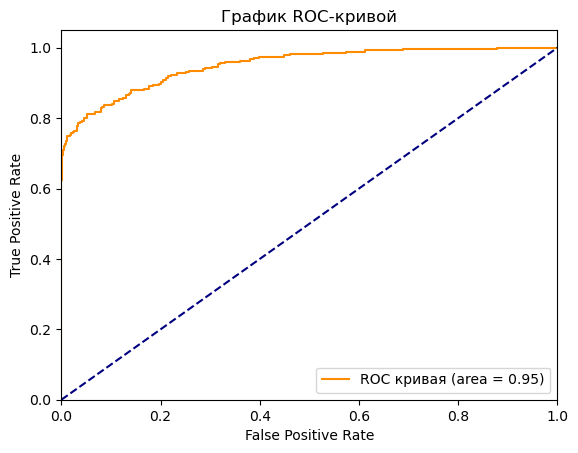

In [60]:
fpr, tpr, treshold = roc_curve(target_test, predictions)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('График ROC-кривой')
plt.legend(loc="lower right")
plt.show()

Пунктирная линия делит поле напополам, обозначая собой 50%, наша кривая покрывает 95% площади прямоугольника в соотвествии с этой метрикой

In [61]:
predictions = grid.best_estimator_.predict(features_test)

accuracy = accuracy_score(target_test, predictions)
print('Accuracy модели:', accuracy)

Accuracy модели: 0.9511641113003975


Точность метрики Accuracy составляет 0.95. Метрика ROC_AUC считается более сбалансированной.

В общем случае accuracy = (tp + tn) / (tp + fp + fn + tn)

Посмотрим матрицу ошибок и проанализируем результат:

In [62]:
cm = confusion_matrix(target_test, predictions)
cm

array([[1480,    6],
       [  80,  195]], dtype=int64)

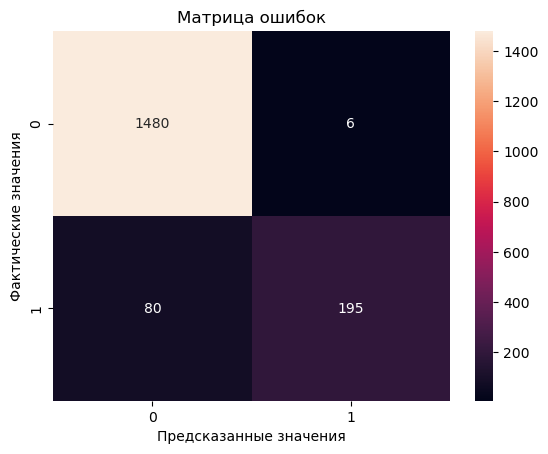

In [63]:
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Матрица ошибок')
plt.xlabel('Предсказанные значения')
plt.ylabel('Фактические значения')
plt.show()

- 1480: это количество объектов, для которых модель правильно предсказала класс 0 (True Negative). Это означает, что модель классифицировала эти объекты правильно, и они были на самом деле отнесены к классу 0.
- 6: это количество объектов, для которых модель неправильно предсказала класс 1, вместо класса 0 (False Positive). Это означает, что модель неправильно классифицировала эти объекты и отнесла их к классу 1, хотя они на самом деле относятся к классу 0.
- 80: это количество объектов, для которых модель неправильно предсказала класс 0, вместо класса 1 (False Negative). Это означает, что модель неправильно классифицировала эти объекты и отнесла их к классу 0, хотя они на самом деле относятся к классу 1.
- 195: это количество объектов, для которых модель правильно предсказала класс 1 (True Positive). Это означает, что модель правильно классифицировала эти объекты, и они были на самом деле отнесены к классу 1.

In [64]:
result = pd.DataFrame(
    [linear_roc_auc, rand_forest_roc_auc, catboost_roc_auc], 
    index=['LogisticRegression', 'RandomForest', 'CatBoost'], 
    columns=['ROC_AUC на кросс-валидации']
)

Общий вывод по важности признаков:

В каждой отдельно взятой модели мы увидели как по разному модели машинного обучения оценивают признаки для прогнозирования метрики. 

- отличительная черта логистической регрессии была в том, что один из ключевых признаков days_using она оценивала как один из самых слабых. Скорее всего именно это повлияло на относительно низкую метрику в roc_auc 0.77
- случайный лес наиболее высоко оценил именно численные признаки в том числе days_using оказался самым важным признаком и это позволило модели показать более высокий показатель качества в roc_auc 0.82
- градиентный бустинг показался самый лучший результат в 0.93 и признак days_using был оценен крайне высоко с кратным отравом. 

Отдельно я бы отметил, что в целом удаление признаков сильно не улучшило ни одну из наших моделей, разница была лишь в тысячных долях. Что может говорить о качественном отборе признаков при постройке корреляции и о хорошей обобщающей способности применяемых моделей. 

## Общий вывод:

В нашем распоряжении оказались данные о клиентах телекоммуникационной компании. Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Перед нами была поставлена задача построить модель машинного обучения, которая будет предсказывать отток клиентов, чтобы мы могли в момент понимания, что клиент склонен, уйти сделать ему мотивирующее предложение. Т.о. мы рещали задачу бинарной классификации с учителем. Важным критерием для клиента является, чтобы модель была интерпретируемой. Оценивали метрикой ROC AUC с целевым значением не менее 0.85.

На основе данных и описания задачи заказчика мы составили технический план работы:
- загрузка и ознакомление с данными
- выделение целевого признака
- формирование синтетических признаков
- заполнение порпусков, устранение аномалий
- объединение данных
- построить графики для визуализации распределния признаков
- построить матрицу распределния признаков, выбрать актуальные
- разделить выборку на тестовую и тренировочну с учетом дизбаланса целевого признака
- построить pipeline с применением трасформатора, масштабирования числовых признаков и OE, OHE кодирование для категориальных признаков
- построить модели логистическую регрессию, случайный лес, catboost, выбрать лучшую из них по кросс-валидации не менее 85% AUC-ROC
- оценить важность признаков по просьбе заказчика для каждой модели
- лучшую модель протестировать на тестовой выборке
- для тестовой модели построить AUC-ROC график и посмотреть accuracy, построить матрицу ошибок 
- общий вывод с рекомендациями

В ходе исследования все его пункты были выполнены. Резюмируя разберем основные этапы и результаты.

 Сначала мы провели загрузку и ознакомление с данными. Мы столкнулись с некоторыми аномалиями и поэтому понадобилась предобработка. Дата сет не очень большой, поэтому мы решили, что удаление данных с аномалиями приведет к потери ценной информации, поэтому мы ничего не удаляли. Мы меняли формат признаков классификации с числового на строчный для удобства, меняли строчные данные TotalCharges на числовые, заменяя пропуски клиентов, которые только подписались, но не успели внести платеж, на нули. Поле EndDate мы использовали как стобец для создания целевого признака, поскольку он не был задлан явно заказчиком. А оставшиеся пропуски мы заполнили датой выгрузки датасета, чтобы сформировать еще один полезный признак - продолжительность использования продукта, который мы назвали days_using. Далее мы объединили таблицы в одну для удобства и обнаружили что у нас есть ряд пропусков в бинарных признаках, где клиент либо пользуется либо не пользуется услугой. Поскольку у нас нет точной информации может ли это быть ошибкой выгрузки, пропуски заполнили значением other.

Для того чтобы лучше понять природу признаков, их взаимосвязь и их распределения с учетом целевого признака мы построили несколько визуализаций - графики, гистограммы, диаграммы. Благодаря ним мы наглядно увидели, что целевой признак имеет дизбаланс классов, что нужно учесть при обучении модели. По графикам по численным признакам мы увидели, что клиенты которые ушли и остались имеют разный характер поведения. В том числе мы отметили, что много клиентов с высоким чеком перестают пользоваться услугами. Диаграммы по признакам классификации не показали явных отличий по клиентам в разрезе целевого признака. 

Для того чтобы понять взаимосвязи признаков с целевым, а так же мультиколлениарность мы построили матрицу коллениарности признаков, а так же тепловую карту. Благодаря ней мы увидели, что ряд признаков очень сильно зависимы, поэтому для повышения качества моделей обучеения мы убрали эти признаки. Таким образом модели обучались на этих признаках: SeniorCitizen, Partner, Type, PaperlessBilling, PaymentMethod, OnlineBackup, MultipleLines, MonthlyCharges, TotalCharges, days_using. Целевой target_class.

Далее мы разделили выборку на тренировочную и тестовую 3 к 1, с учетом дизбаланса классов целевого признака. Мы приняли решение, что построим три модели , выберем лучшую и на ней будем тестировать. Мы выбрали логистическую регрессию, случайный лес и градиентный бустинг над решающими деревьями. Для каждой модели мы составляли отдельный трансформатор признаков: для линейной модели мы применяли OHE кодирование категориальных признаков, и масштабирование численных. А для случайного леса и бустинга применяли ОЕ кодирование кат. признаков и масштабирование численных. Так же для того чтобы избежать утечки данных работу с признаками, мы проводили после того как отделили целевой признак и применяли конвейер. Для того чтобы оптимизировать модели с учетом особенностей данных, мы применяли гридсерч с гиперпараметрами. 
Таким образом мы получили три модели с тремя результатами ROC AUC в качестве целевой метрики на кросс-валидации.

In [65]:
result

,ROC_AUC на кросс-валидации
LogisticRegression,0.765193
RandomForest,0.823639
CatBoost,0.930647


Таким образом мы выясниил что CatBoost лучше всего подходит для применения на тестовой выборке. Лучшие гиперпараметры: 
- 'depth': 2, 
- 'iterations': 1000, 
- 'l2_leaf_reg': 0.01, 
- 'learning_rate': 0.2

В ходе анализа моделей была дана оценка важностей признаков: 
- отличительная черта логистической регрессии была в том, что один из ключевых признаков days_using она оценивала как один из самых слабых. Скорее всего именно это повлияло на относительно низкую метрику в roc_auc 0.77
- случайный лес наиболее высоко оценил именно численные признаки в том числе days_using оказался самым важным признаком и это позволило модели показать более высокий показатель качества в roc_auc 0.82
- градиентный бустинг показался самый лучший результат в 0.93 и признак days_using был оценен крайне высоко с кратным отравом. 

Отдельно я бы отметил, что в целом удаление признаков сильно не улучшило ни одну из наших моделей, разница была лишь в тысячных долях. Что может говорить о качественном отборе признаков при постройке корреляции и о хорошей обобщающей способности применяемых моделей. 

На тестовой выборке мы получили roc_auc 0.95, таким образом мы можем считать задачу выполненной. 

Для лучшей интерпретации и понимания природы полученных данных мы так же получили значение accuracy которое оказалось равно 0.95, построили график ROC и построили матрицу ошибок с подробным описанием: 
- 1480: это количество объектов, для которых модель правильно предсказала класс 0 (Остались) (True Negative). Это означает, что модель классифицировала эти объекты правильно, и они были на самом деле отнесены к классу 0 (Остались).
- 6: это количество объектов, для которых модель неправильно предсказала класс 1 (Ушли), вместо класса 0 (False Positive). Это означает, что модель неправильно классифицировала эти объекты и отнесла их к классу 1 (Ушли), хотя они на самом деле относятся к классу 0 (Остались).
- 80: это количество объектов, для которых модель неправильно предсказала класс 0 (Остались), вместо класса 1 (Ушли) (False Negative). Это означает, что модель неправильно классифицировала эти объекты и отнесла их к классу 0 (Остались), хотя они на самом деле относятся к классу 1 (Ушли).
- 195: это количество объектов, для которых модель правильно предсказала класс 1 (Ушли) (True Positive). Это означает, что модель правильно классифицировала эти объекты, и они были на самом деле отнесены к классу 1 (Ушли).

## Рекомендации:
Бизнес задача заключалась в том, что нужно научиться правильно отслеживать тех клиентов, которые собираются уйти, поэтому я бы посоветовал заказчику переработать полученную модель. 
- Точность (precision) в нашем случае равна 0.97, в то время как 
- Полнота (recall) равна 0.71  

Для нашей бизнес задачи у нас слишком высокий порог принятия решений. Нам нужно понизить порог, чтобы повысить recall. Мы видим, что наша модель научилась хорошо определять тех клиентов которые остались 1480 ошибочно предсказав 6 которые на самом деле ушли. С другой стороны она предсказала, что 195 клиентов ушли при том ошибочно предсказав 80 что они остались хотя на самом деле ушли. Я бы посоветовал переработать модель, чтобы она научилась лучше определять именно тех, кто собираются уходить. На мой взгляд будет лучше, если модель будет больше ошибаться, что клиент остался, чем ушел. 

Так же еще на моменте анализа графиков я обратил внимание, что уходит большое количество клиентов, у которых суммарный чек выше обычного. На мой взгляд заказчику следует разработать несколько разных промокодов, чтобы рассылать ключевым клиентам наиболее "вкусные" предложения, чтобы повысить шанс удержать таких клиентов, т.е. ввести ранжирование предложений для разных аудиторий клиентов,в зависимости от суммарного чека. 

Кроме того на моменте заполнения пропусков много значений были заполнены нейтральными значениями. Более подробная информация от заказчика так же улучшила качество метрик. 